In [10]:
import glacierml as gl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pth = '/data/fast1/glacierml/data/'
pd.set_option('display.max_columns', None)
import configparser
import cartopy.crs as crs
import cartopy.feature as cfeature

In [2]:
RGI = gl.load_RGI()

In [3]:
parameterization = '1'
config = configparser.ConfigParser()
config.read('model_parameterization.txt')

data = gl.load_training_data(
    root_dir = '/data/fast1/glacierml/data/',
    area_scrubber = config[parameterization]['area scrubber'],
    anomaly_input = float(   config[parameterization]['size threshold']   )
)
data = data.drop(
    data[data['distance test'] >= float(config[parameterization]['distance threshold']  
                                            )].index
)

# data = data.drop([
#     'RGIId','region', 'RGI Centroid Distance', 
#     'AVG Radius', 'Roundness', 
#         'distance test', 
#     'size difference'
# ], axis = 1)
data

,RGIId,CenLat,CenLon,Area,Zmin,Zmed,Zmax,Slope,Aspect,Lmax,Thickness,region,size difference,RGI Centroid Distance,AVG Radius,Roundness,distance test
0,RGI60-01.00037,63.469173,-146.528168,234.583,722,1841,3081,12.0,30,41911,235.0,01,0.046411,1851.480653,8641.185569,0.206179,0.214262
1,RGI60-01.00570,63.281000,-145.427000,17.567,1162,1858,2438,14.0,172,8639,147.0,01,0.090735,707.576070,2364.688092,0.273722,0.299226
2,RGI60-01.01104,58.380000,-134.349000,9.528,676,1123,1494,10.0,327,6332,66.0,01,0.185641,643.556206,1741.509861,0.275033,0.369539
3,RGI60-01.02236,69.276000,-143.819000,0.153,2360,2440,2554,22.0,219,680,83.0,01,0.979324,622.846071,220.683965,0.324535,2.822344
4,RGI60-01.02236,69.276000,-143.819000,0.153,2360,2440,2554,22.0,219,680,82.0,01,0.974585,622.846071,220.683965,0.324535,2.822344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,RGI60-19.01012,-65.052700,-63.393600,0.213,10,-999,50,0.0,-9,318,312.0,19,0.999174,77370.878372,260.384342,0.818819,297.141056
496,RGI60-19.01950,-62.047200,-58.376500,7.240,30,-999,630,7.4,150,5187,238.0,19,0.984430,2079.113914,1518.078910,0.292670,1.369569
497,RGI60-19.02058,-62.675200,-60.390600,1.160,10,-999,370,10.0,260,1118,89.0,19,0.754757,1013.640365,607.650778,0.543516,1.668130
498,RGI60-19.02059,-62.670700,-60.354700,5.493,10,-999,370,6.7,273,3056,97.0,19,0.020856,193.860066,1322.299590,0.432690,0.146608


In [11]:
def analyze(df = data, verbose = False):

    # df1['Area'] = np.log(df1['Area'])
    # dataset['Lmax'] = dataset['Lmax'] * 1e3
    # dataset['Lmax'] = np.log(dataset['Lmax'])
    df.name = 'df'
#     print(df)

    # lr_input = 0.01
    rs = 0
    # ep_input = 2000
    layer_1_input = 20
    layer_2_input = 15
    dropout = True

    dnn_model = gl.build_and_train_model(
                            df, 
    #                         learning_rate = float(lr_input), 
    #                         random_state = rs, 
    #                         epochs = int(ep_input), 
                            parameterization = parameterization, 
#                             res = res,
                            layer_1 = layer_1_input,
                            layer_2 = layer_2_input,
                            dropout = dropout,
                            writeToFile = False,
                            loss = 'mean_absolute_error'
    )   

    model_thicknesses = gl.evaluate_model(
        str(layer_1_input) + '-' + str(layer_2_input), rs, df,
        dnn_model, parameterization = parameterization
    )
    model_thicknesses
    
    if verbose:
    
        plt.scatter(
            model_thicknesses['E&L Thickness'],
            model_thicknesses['GlaThiDa Thickness'],
            marker = '.')
        plt.xlabel('E&L Thickness')
        plt.ylabel('GlaThiDa Thickness')
        plt.plot(
            [model_thicknesses['GlaThiDa Thickness'].min(),
            model_thicknesses['GlaThiDa Thickness'].max()],
            [model_thicknesses['GlaThiDa Thickness'].min(),
            model_thicknesses['GlaThiDa Thickness'].max()],

            c = 'red'
        )
        os = list(df)
        os = [ele for ele in os if ele != 'Thickness']

        plt.title(", ".join(os))
        plt.show()
    return model_thicknesses

# With ALL data

In [12]:
df1 = data[['CenLat', 'CenLon', 'Zmin', 
               'Zmed',
               'Zmax',
               'Aspect',
               'Lmax',
               'Slope', 'Area', 'Thickness']]
model_thicknesses1 = analyze(df1)

# No geographic location

In [13]:
df2 = data[['Zmin', 
               'Zmed', 
               'Zmax',
               'Aspect',
               'Lmax',
               'Slope', 'Area', 'Thickness']]
model_thicknesses2 = analyze(df2)

# No geographic or elevation data

In [14]:
df3 = data[[
    'Lmax',
    'Slope', 'Area', 'Thickness']]
model_thicknesses3 = analyze(df3)

# Include Roundness

In [15]:
df4 = pd.concat([df1, data['Roundness']], axis =1 )
model_thicknesses4 = analyze(df4)

In [16]:
df5 = pd.concat([df2, data['Roundness']], axis =1 )
model_thicknesses5 = analyze(df5)

In [17]:
df6 = pd.concat([df3, data['Roundness']], axis =1 )
model_thicknesses6 = analyze(df6)

# Look at it all at once

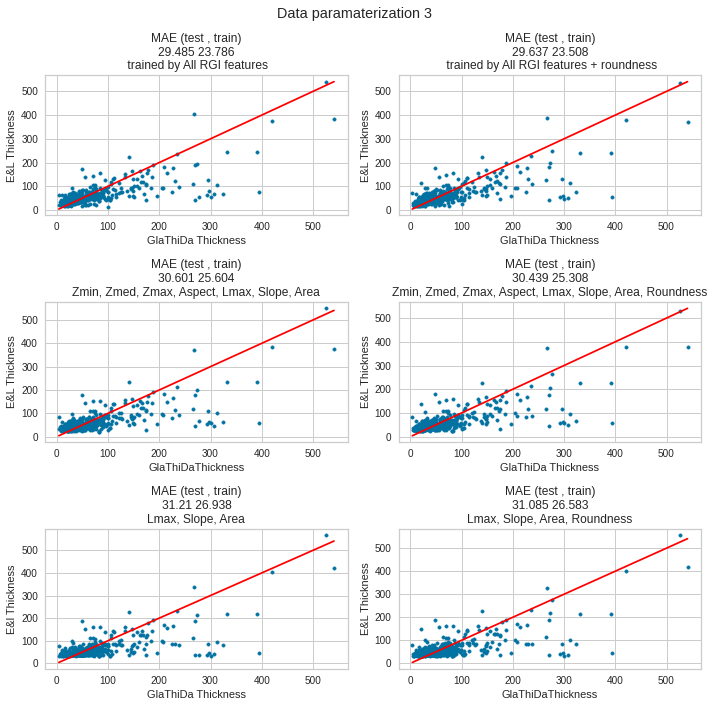

In [19]:
fig, axs = plt.subplots(3, 2, figsize = (10,10))
# for n in range(0)
axs[0, 0].scatter(
    model_thicknesses1['GlaThiDa Thickness'],
    model_thicknesses1['E&L Thickness'],
    marker = '.'
)
axs[0, 0].plot(
    [model_thicknesses1['GlaThiDa Thickness'].min(),
    model_thicknesses1['GlaThiDa Thickness'].max()],
    [model_thicknesses1['GlaThiDa Thickness'].min(),
    model_thicknesses1['GlaThiDa Thickness'].max()],

    c = 'red'
)
os = list(df1)
os = [ele for ele in df1 if ele != 'Thickness']
axs[0, 0].set_title(
    'MAE (test , train)\n'+
    str(np.round(model_thicknesses1['test mae'].loc[0], 3))+ ' ' +
    str(
        np.round(model_thicknesses1['train mae'].loc[0], 3)
    ) + 
    '\n trained by All RGI features'
                   )
axs[0, 0].set_xlabel('GlaThiDa Thickness')
axs[0, 0].set_ylabel('E&L Thickness')


axs[0, 1].scatter(
    model_thicknesses4['GlaThiDa Thickness'],
    model_thicknesses4['E&L Thickness'],
    marker = '.'
)
axs[0, 1].plot(
    [model_thicknesses4['GlaThiDa Thickness'].min(),
    model_thicknesses4['GlaThiDa Thickness'].max()],
    [model_thicknesses4['GlaThiDa Thickness'].min(),
    model_thicknesses4['GlaThiDa Thickness'].max()],

    c = 'red'
)
os = list(df4)
os = [ele for ele in df4 if ele != 'Thickness']

axs[0,1].set_title(
        'MAE (test , train)\n'+

    str(np.round(model_thicknesses4['test mae'].loc[0], 3))+ ' ' +
    str(np.round(model_thicknesses4['train mae'].loc[0], 3)) + 
   '\n trained by All RGI features + roundness')

axs[0, 1].set_xlabel('GlaThiDa Thickness')
axs[0, 1].set_ylabel('E&L Thickness')

axs[1, 0].scatter(
    model_thicknesses2['GlaThiDa Thickness'],
    model_thicknesses2['E&L Thickness'],
    marker = '.'
)
axs[1, 0].plot(
    [model_thicknesses2['GlaThiDa Thickness'].min(),
    model_thicknesses2['GlaThiDa Thickness'].max()],
    [model_thicknesses2['GlaThiDa Thickness'].min(),
    model_thicknesses2['GlaThiDa Thickness'].max()],

    c = 'red'
)
os = list(df2)
os = [ele for ele in df2 if ele != 'Thickness']

# plt.title(", ".join(os))
axs[1, 0].set_title(
        'MAE (test , train)\n'+
        str(np.round(model_thicknesses2['test mae'].loc[0], 3))+ ' ' +
        str(np.round(model_thicknesses2['train mae'].loc[0], 3)) + '\n'+", ".join(os))


axs[1, 0].set_xlabel('GlaThiDaThickness')
axs[1, 0].set_ylabel('E&L Thickness')



axs[1, 1].scatter(
    model_thicknesses5['GlaThiDa Thickness'],
    model_thicknesses5['E&L Thickness'],
    marker = '.'
)
axs[1, 1].plot(
    [model_thicknesses5['GlaThiDa Thickness'].min(),
    model_thicknesses5['GlaThiDa Thickness'].max()],
    [model_thicknesses5['GlaThiDa Thickness'].min(),
    model_thicknesses5['GlaThiDa Thickness'].max()],

    c = 'red'
)
os = list(df5)
os = [ele for ele in df5 if ele != 'Thickness']

# plt.title(", ".join(os))
axs[1, 1].set_title(
        'MAE (test , train)\n'+
        str(np.round(model_thicknesses5['test mae'].loc[0], 3))+ ' ' +
        str(np.round(model_thicknesses5['train mae'].loc[0], 3)) + '\n'+", ".join(os))
axs[1, 1].set_xlabel('GlaThiDa Thickness')
axs[1, 1].set_ylabel('E&L Thickness')



axs[2, 0].scatter(
    model_thicknesses3['GlaThiDa Thickness'],
    model_thicknesses3['E&L Thickness'],
    marker = '.'
)
axs[2, 0].plot(
    [model_thicknesses3['GlaThiDa Thickness'].min(),
    model_thicknesses3['GlaThiDa Thickness'].max()],
    [model_thicknesses3['GlaThiDa Thickness'].min(),
    model_thicknesses3['GlaThiDa Thickness'].max()],

    c = 'red'
)
os = list(df3)
os = [ele for ele in df3 if ele != 'Thickness']

# plt.title(", ".join(os))
axs[2, 0].set_title(
        'MAE (test , train)\n'+
        str(np.round(model_thicknesses3['test mae'].loc[0], 3))+ ' ' +
        str(np.round(model_thicknesses3['train mae'].loc[0], 3)) + '\n'+", ".join(os))

axs[2, 0].set_xlabel('GlaThiDa Thickness')
axs[2, 0].set_ylabel('E&l Thickness')



axs[2, 1].scatter(
    model_thicknesses6['GlaThiDa Thickness'],
    model_thicknesses6['E&L Thickness'],
    marker = '.'
)
axs[2, 1].plot(
    [model_thicknesses6['GlaThiDa Thickness'].min(),
    model_thicknesses6['GlaThiDa Thickness'].max()],
    [model_thicknesses6['GlaThiDa Thickness'].min(),
    model_thicknesses6['GlaThiDa Thickness'].max()],

    c = 'red'
)
os = list(df6)
os = [ele for ele in df6 if ele != 'Thickness']


# plt.title(", ".join(os))
axs[2, 1].set_title(
        'MAE (test , train)\n'+
        str(np.round(model_thicknesses6['test mae'].loc[0], 3))+ ' ' +
        str(np.round(model_thicknesses6['train mae'].loc[0], 3))+ '\n'+", ".join(os))


axs[2, 1].set_xlabel('GlaThiDaThickness')
axs[2, 1].set_ylabel('E&L Thickness')
plt.suptitle('Data paramaterization ' + parameterization)

plt.tight_layout()

In [20]:
dft = model_thicknesses4.sort_values('Residual', ascending = False)

In [21]:
dft[dft['Residual'] == dft['Residual'].max()]

,CenLat,CenLon,Zmin,Zmed,Zmax,Aspect,Lmax,Slope,Area,Roundness,model,test mae,train mae,layer architecture,parameterization,total parameters,GlaThiDa Thickness,E&L Thickness,Residual
16,-47.0606,-73.2963,1197,1430,1580,149,779,31.5,0.292,0.391362,0,29.636833,23.50771,20-15,3,572,394.0,52.768326,341.231674


In [22]:
dft[dft['Residual'] == dft['Residual'].min()]

,CenLat,CenLon,Zmin,Zmed,Zmax,Aspect,Lmax,Slope,Area,Roundness,model,test mae,train mae,layer architecture,parameterization,total parameters,GlaThiDa Thickness,E&L Thickness,Residual
413,78.6511,13.8202,84,525,1026,138,32195,8.2,165.161,0.225211,0,29.636833,23.50771,20-15,3,572,49.0,175.499847,-126.499847


In [23]:
dft['Lmax'][(dft['Residual'] >= -5) & (dft['Residual'] <=0)].median()

2188.0

In [24]:
sum(dft['Residual'])

4221.241094589233

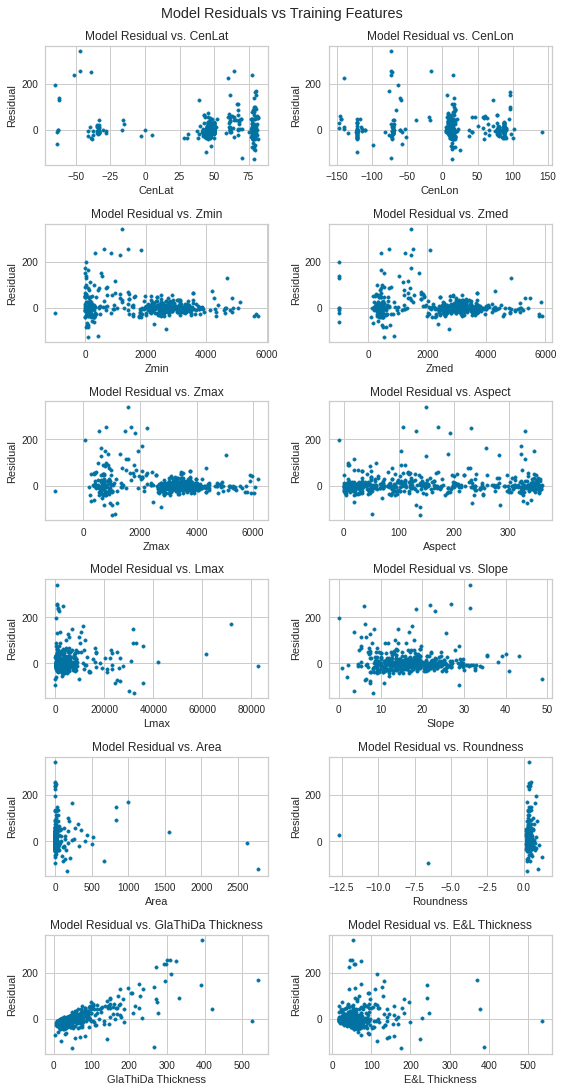

In [26]:
fig = plt.subplots(6,2, figsize = (8,15))

for n, i in enumerate([
    'CenLat', 'CenLon','Zmin','Zmed','Zmax',
          'Aspect',
    'Lmax','Slope','Area','Roundness', 'GlaThiDa Thickness','E&L Thickness']):
#     print(i)
    ax = plt.subplot(6,2,n+1)
    ax.scatter(
        
        (dft[i]),
        (dft['Residual']),
        marker = '.'
    )
    ax.set_ylabel('Residual')
    ax.set_xlabel(i)
#     ax.set_yscale('log')
#     ax.set_xscale('log')
    ax.set_title('Model Residual vs. '+ i )
plt.tight_layout()
plt.suptitle('Model Residuals vs Training Features', y = 1.01)
plt.show()
    